# Heat Flux Feature Imputation

**Context**: This dataset was prepared for the journal article entitled _"On the prediction of critical heat flux using a physics-informed machine learning-aided framework"_ (doi: 10.1016/j.applthermaleng.2019.114540). The dataset contains processed and compiled records of experimental critical heat flux and boundary conditions used for the work presented in the article.

**Goal**: Through the provided features impute the `x_e_out [-]`.

**Feature Description**:
- Geometry[-]: geometry of the heat source
- Pressure [Mpa]: Pressure inside the boiler
- Length [mm]: the heated length of the heat source
- Dh [mm]: channel heated diameter
- De [mm]: channel equivalent (or hydraulic) diameter
- chf_exp: Experimental critical heat flux [MW/m2]
- mass_flux [kg/m2 s]: In physics and engineering, mass flux is the rate of mass flow
- x_e [-]: loca/exit equilibrium (or thermodynamic) quality

**Resources**:
- [Kaggle Challenge](https://www.kaggle.com/competitions/playground-series-s3e15/overview)
- [Dataset](https://www.kaggle.com/datasets/saurabhshahane/predicting-heat-flux)

In [23]:
# Import Standard Libraries
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import seaborn as sns

import mlflow

from pathlib import Path
from colorama import Style, Fore

In [2]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'font.family': 'Andale Mono',
    'axes.titlesize': 24,
    'figure.facecolor': '#E5E8E8',
    'axes.facecolor': '#E5E8E8'
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('deep'), 
              rc=theme_parameters)

In [3]:
# Define Colors
black = Style.BRIGHT + Fore.BLACK
magenta = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blue = Style.BRIGHT + Fore.BLUE
reset_colors = Style.RESET_ALL

# Read Data

In [6]:
# Switch flag for Kaggle Cloud
kaggle = False

# Switch flag for including original dataset
include_original_data = True

In [8]:
# Read training data
if kaggle:
    
    # Read data from Kaggle FS
    data = pd.read_csv('/kaggle/input/playground-series-s3e15/data.csv')
    original_data = pd.read_csv('/kaggle/input/originacsv/heat_flux_feature_imputation_original.csv')
    
else:
    
    # Define local data file paths
    data_file_path = Path(os.path.abspath('')).parents[1] / 'data' / 'S3E15' / 'heat_flux_feature_imputation_data.csv'
    original_data_file_path = Path(os.path.abspath('')).parents[1] / 'data' / 'S3E15' / 'heat_flux_feature_imputation_original.csv'
   
    data = pd.read_csv(data_file_path)
    original_data = pd.read_csv(original_data_file_path)

In [9]:
data.head()

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31644 entries, 0 to 31643
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   31644 non-null  int64  
 1   author               26620 non-null  object 
 2   geometry             26144 non-null  object 
 3   pressure [MPa]       27192 non-null  float64
 4   mass_flux [kg/m2-s]  26853 non-null  float64
 5   x_e_out [-]          21229 non-null  float64
 6   D_e [mm]             26156 non-null  float64
 7   D_h [mm]             27055 non-null  float64
 8   length [mm]          26885 non-null  float64
 9   chf_exp [MW/m2]      31644 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.4+ MB


Since there are some null values in the `x_e_out [-]`, the data would be splitted as follow:
- Train Data: entries with `x_e_out [-]` non-null
- Test Data: entries with `x_e_out [-]` null

## Define Train and Test Data

In [14]:
# Define train_data
train_data = data[data['x_e_out [-]'].notnull()]

In [16]:
# Define test_data
test_data = data[data['x_e_out [-]'].isnull()]

# Exploratory Data Analysis (EDA)

## Shapes Information

In [17]:
# Print shapes information
print(f'{blue}Data Shapes:'
      f'{blue}\n- Train Data     -> {red}{train_data.shape}'
      f'{blue}\n- Original Data  -> {red}{original_data.shape}'
      f'{blue}\n- Test Data      -> {red}{test_data.shape}\n')

Data Shapes:
- Train Data     -> (21229, 10)
- Original Data  -> (1865, 10)
- Test Data      -> (10415, 10)



## Null Values Information

In [21]:
# Print null values information
print(f'{blue}Data Columns with Null Values:'
      f'{blue}\n- Train Data     -> {red}{train_data.isnull().any().sum()}'
      f'{blue}\n- Original Data  -> {red}{original_data.isnull().any().sum()}'
      f'{blue}\n- Test Data      -> {red}{test_data.isnull().any().sum()}\n')

Data Columns with Null Values:
- Train Data     -> 7
- Original Data  -> 0
- Test Data      -> 8



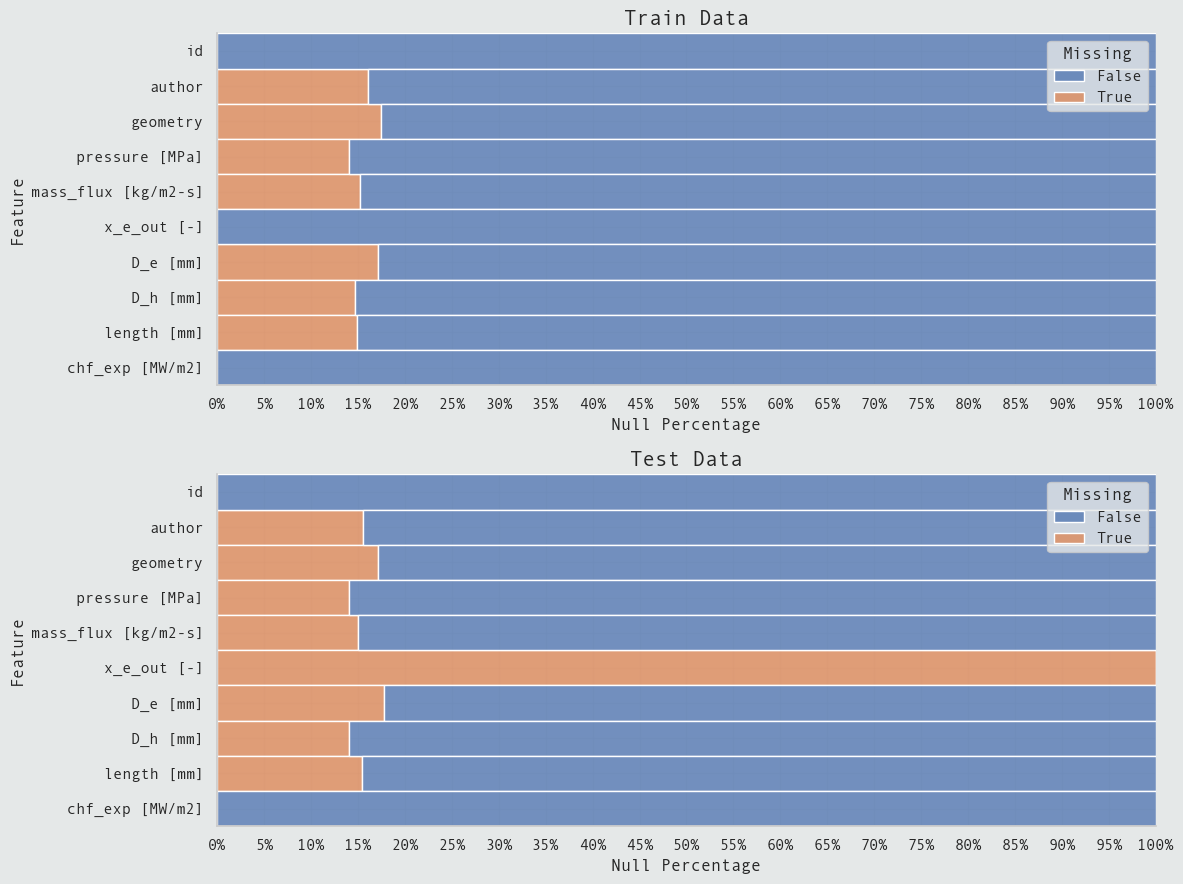

In [25]:
# Define data to display
data_to_display = {
    'Train Data': train_data,
    'Test Data': test_data
}

# Create figure
figure = plt.figure(tight_layout=True, figsize=(12, 9))

# Define figure's subplots
grid_spec = GridSpec(len(data_to_display), 1)

# Fetch data to plot
for row, (name, dataframe) in enumerate(data_to_display.items()):
    
    # Create subplot
    ax = figure.add_subplot(grid_spec[row, 0])
    
    sns.histplot(data=dataframe.isna().melt(var_name='Feature', value_name='Missing'), 
                 y='Feature', 
                 hue='Missing', 
                 multiple='fill',
                 ax=ax)
    
    # Refactor x label as missing percentage
    ax.xaxis.set_major_locator(ticker.LinearLocator(21))
    ax.xaxis.set_major_formatter('{:.0%}'.format)
    
    # Set title and label
    ax.set_title(name, fontsize=15)
    ax.set_xlabel('Null Percentage')

There is quite a huge amount of null values in most of the columns. Around 15% in all the features. Need to come up with a strategy for dealing with those.

## Train vs Test vs Original Numerical Feature Distribution

In [27]:
# Define raw numerical features
raw_numerical_features = ['pressure [MPa]', 
                          'mass_flux [kg/m2-s]', 
                          'D_e [mm]', 
                          'D_h [mm]', 
                          'length [mm]', 
                          'chf_exp [MW/m2]']

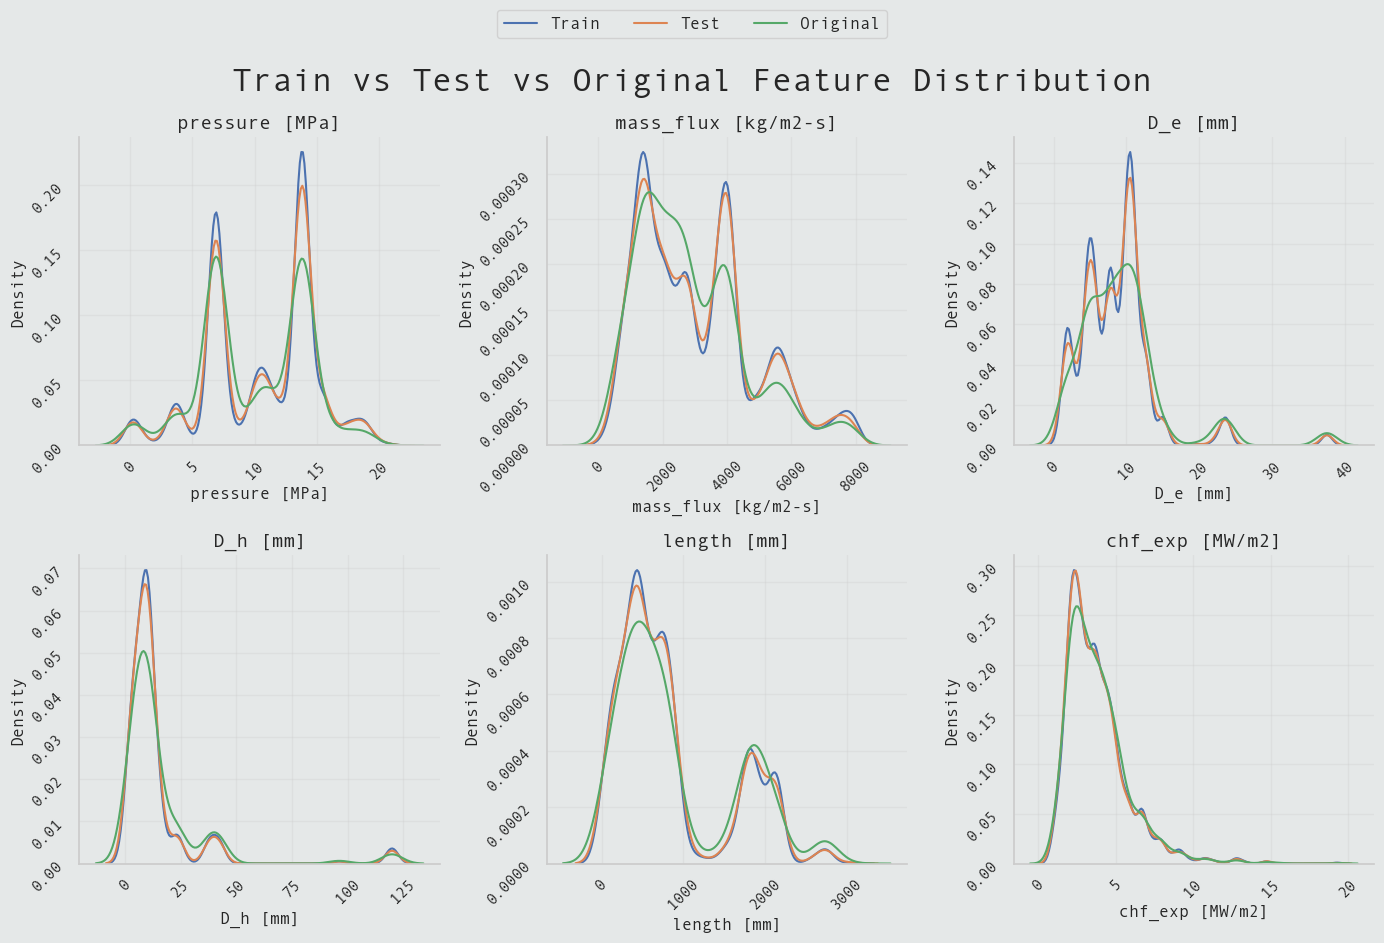

In [31]:
# Plot the KDE of each feature
figure, ax = plt.subplots(2, 3, figsize=(14, 9))
ax = ax.flatten()

# Fetch the data to plot (exclude the 'id' and 'label' columns)
for index, column_name in enumerate(raw_numerical_features):
    
    # Plot data
    sns.kdeplot(data=train_data[column_name],
                label='Train',
                ax=ax[index])
    
    sns.kdeplot(data=test_data[column_name],
                label='Test',
                ax=ax[index])
    
    sns.kdeplot(data=original_data[column_name],
                label='Original',
                ax=ax[index])
    
    ax[index].set_title(column_name, fontsize=14)
    
    ax[index].tick_params(labelrotation=45)
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()

# Set the legend
figure.legend(handles, 
              labels, 
              loc='center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=12,
              ncol=3)

figure.suptitle('Train vs Test vs Original Feature Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

- `D_h [mm]` and `chf_exp [MW/m2` are strongly right-skewed
- `length [mm]` follows a Binomial distribution